In [2]:
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture
from scipy.signal import find_peaks
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

def get_dynamic_threshold_methods():
    """Return a dictionary of different threshold detection methods"""
    return {
        'gmm': find_threshold_gmm,
        'kernel_density': find_threshold_kde,
        'otsu': find_threshold_otsu,
        'zscore': find_threshold_zscore,
        'iqr': find_threshold_iqr
    }

def find_threshold_gmm(pcc_values):
    """
    Find threshold using Gaussian Mixture Model to detect bimodality
    
    Args:
        pcc_values: Array of PCC values
    
    Returns:
        threshold: Optimal threshold between the two distributions
        is_bimodal: Boolean indicating if distribution is bimodal
    """
    # Reshape for GMM
    X = pcc_values.reshape(-1, 1)
    
    # Fit GMM with 2 components
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(X)
    
    # Get means and standard deviations
    means = gmm.means_.flatten()
    stds = np.sqrt(gmm.covariances_.flatten())
    weights = gmm.weights_
    
    # Check if distribution is actually bimodal
    mean_diff = abs(means[0] - means[1])
    std_avg = (stds[0] + stds[1]) / 2
    is_bimodal = mean_diff > 2 * std_avg  # Using 2 standard deviations as criterion
    
    if is_bimodal:
        # Find the intersection point of the two Gaussians
        a = 1/(2*stds[0]**2) - 1/(2*stds[1]**2)
        b = means[1]/(stds[1]**2) - means[0]/(stds[0]**2)
        c = means[0]**2 /(2*stds[0]**2) - means[1]**2 /(2*stds[1]**2) - np.log(weights[1]/weights[0])
        threshold = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)
    else:
        # If not bimodal, use more conservative threshold
        threshold = min(means) - 2 * max(stds)
    
    return threshold, is_bimodal

def find_threshold_kde(pcc_values, bandwidth=0.1):
    """
    Find threshold using Kernel Density Estimation to detect valleys in distribution
    """
    # Fit KDE
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(pcc_values.reshape(-1, 1))
    
    # Evaluate KDE on a grid
    x_grid = np.linspace(pcc_values.min(), pcc_values.max(), 1000).reshape(-1, 1)
    log_dens = kde.score_samples(x_grid)
    
    # Find valleys (local minima) in the density
    valleys, _ = find_peaks(-log_dens)
    
    if len(valleys) > 0:
        # Return the valley point with highest density as threshold
        threshold = x_grid[valleys[np.argmax(log_dens[valleys])]][0]
        is_bimodal = True
    else:
        # If no valleys found, use standard deviation based threshold
        threshold = np.mean(pcc_values) - 2 * np.std(pcc_values)
        is_bimodal = False
    
    return threshold, is_bimodal

def find_threshold_otsu(pcc_values):
    """
    Find threshold using Otsu's method
    """
    # Convert PCC values to histogram
    hist, bin_edges = np.histogram(pcc_values, bins=100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate cumulative sums
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    
    # Calculate means
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    
    # Calculate variance between classes
    variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    
    # Find optimal threshold
    optimal_idx = np.argmax(variance)
    threshold = bin_centers[optimal_idx]
    
    # Check if distribution is bimodal using the variance
    is_bimodal = np.max(variance) > np.mean(variance) * 2
    
    return threshold, is_bimodal

def find_threshold_zscore(pcc_values, z_threshold=2.5):
    """
    Find threshold using Z-score method
    """
    mean = np.mean(pcc_values)
    std = np.std(pcc_values)
    threshold = mean - z_threshold * std
    
    # Check if distribution is significantly skewed
    is_bimodal = stats.skew(pcc_values) < -0.5
    
    return threshold, is_bimodal

def find_threshold_iqr(pcc_values, iqr_factor=1.5):
    """
    Find threshold using IQR method
    """
    q1, q3 = np.percentile(pcc_values, [25, 75])
    iqr = q3 - q1
    threshold = q1 - iqr_factor * iqr
    
    # Check if distribution has significant outliers
    is_bimodal = len(pcc_values[pcc_values < threshold]) / len(pcc_values) > 0.01
    
    return threshold, is_bimodal

def analyze_pcc_distribution(pcc_values, plot=True):
    """
    Analyze PCC distribution and suggest optimal threshold
    """
    methods = get_dynamic_threshold_methods()
    thresholds = {}
    
    for name, method in methods.items():
        threshold, is_bimodal = method(pcc_values)
        thresholds[name] = {'threshold': threshold, 'is_bimodal': is_bimodal}
    
    if plot:
        plt.figure(figsize=(15, 10))
        
        # Plot histogram
        plt.hist(pcc_values, bins=100, density=True, alpha=0.6, color='gray')
        
        # Plot KDE
        kde = KernelDensity(bandwidth=0.1)
        kde.fit(pcc_values.reshape(-1, 1))
        x_grid = np.linspace(pcc_values.min(), pcc_values.max(), 1000)
        log_dens = kde.score_samples(x_grid.reshape(-1, 1))
        plt.plot(x_grid, np.exp(log_dens), 'k-', lw=2, label='KDE')
        
        # Plot thresholds
        colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
        for (name, result), color in zip(thresholds.items(), colors):
            plt.axvline(result['threshold'], color=color, linestyle='--', 
                       label=f"{name} (threshold={result['threshold']:.3f})")
        
        plt.xlabel('PCC Value')
        plt.ylabel('Density')
        plt.title('PCC Distribution Analysis')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return thresholds

def calculate_detection_metrics_dynamic(original_data, anomalous_data, reconstructed_data, 
                                     anomaly_mask, method='gmm'):
    """
    Calculate detection metrics using dynamic threshold
    """
    # Calculate PCC values for all pixels
    height, width = anomaly_mask.shape
    pcc_values = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width):
            pcc_values[i, j] = calculate_pcc(anomalous_data[i, j], reconstructed_data[i, j])
    
    # Find threshold
    threshold_method = get_dynamic_threshold_methods()[method]
    threshold, is_bimodal = threshold_method(pcc_values.flatten())
    
    # Calculate metrics using dynamic threshold
    anomaly_coords = np.argwhere(anomaly_mask > 0)
    normal_coords = np.argwhere(anomaly_mask == 0)
    
    true_positives = sum(pcc_values[y, x] < threshold for y, x in anomaly_coords)
    false_positives = sum(pcc_values[y, x] < threshold for y, x in normal_coords)
    
    total_anomalies = len(anomaly_coords)
    total_normal = len(normal_coords)
    
    metrics = {
        'true_positive_rate': true_positives / total_anomalies if total_anomalies > 0 else 0,
        'false_positive_rate': false_positives / total_normal if total_normal > 0 else 0,
        'threshold': threshold,
        'is_bimodal': is_bimodal
    }
    
    return metrics

# Example usage in your processing pipeline:
"""
# In your worker function:
pcc_values = np.zeros((height, width))
for i in range(height):
    for j in range(width):
        pcc_values[i, j] = calculate_pcc(anomalous_data[i, j], reconstructed_data[i, j])

# Analyze distribution
thresholds = analyze_pcc_distribution(pcc_values.flatten(), plot=True)

# Calculate metrics using different methods
metrics = {}
for method in get_dynamic_threshold_methods().keys():
    metrics[method] = calculate_detection_metrics_dynamic(
        original_data, anomalous_data, reconstructed_data, 
        anomaly_mask, method=method
    )
"""

'\n# In your worker function:\npcc_values = np.zeros((height, width))\nfor i in range(height):\n    for j in range(width):\n        pcc_values[i, j] = calculate_pcc(anomalous_data[i, j], reconstructed_data[i, j])\n\n# Analyze distribution\nthresholds = analyze_pcc_distribution(pcc_values.flatten(), plot=True)\n\n# Calculate metrics using different methods\nmetrics = {}\nfor method in get_dynamic_threshold_methods().keys():\n    metrics[method] = calculate_detection_metrics_dynamic(\n        original_data, anomalous_data, reconstructed_data, \n        anomaly_mask, method=method\n    )\n'

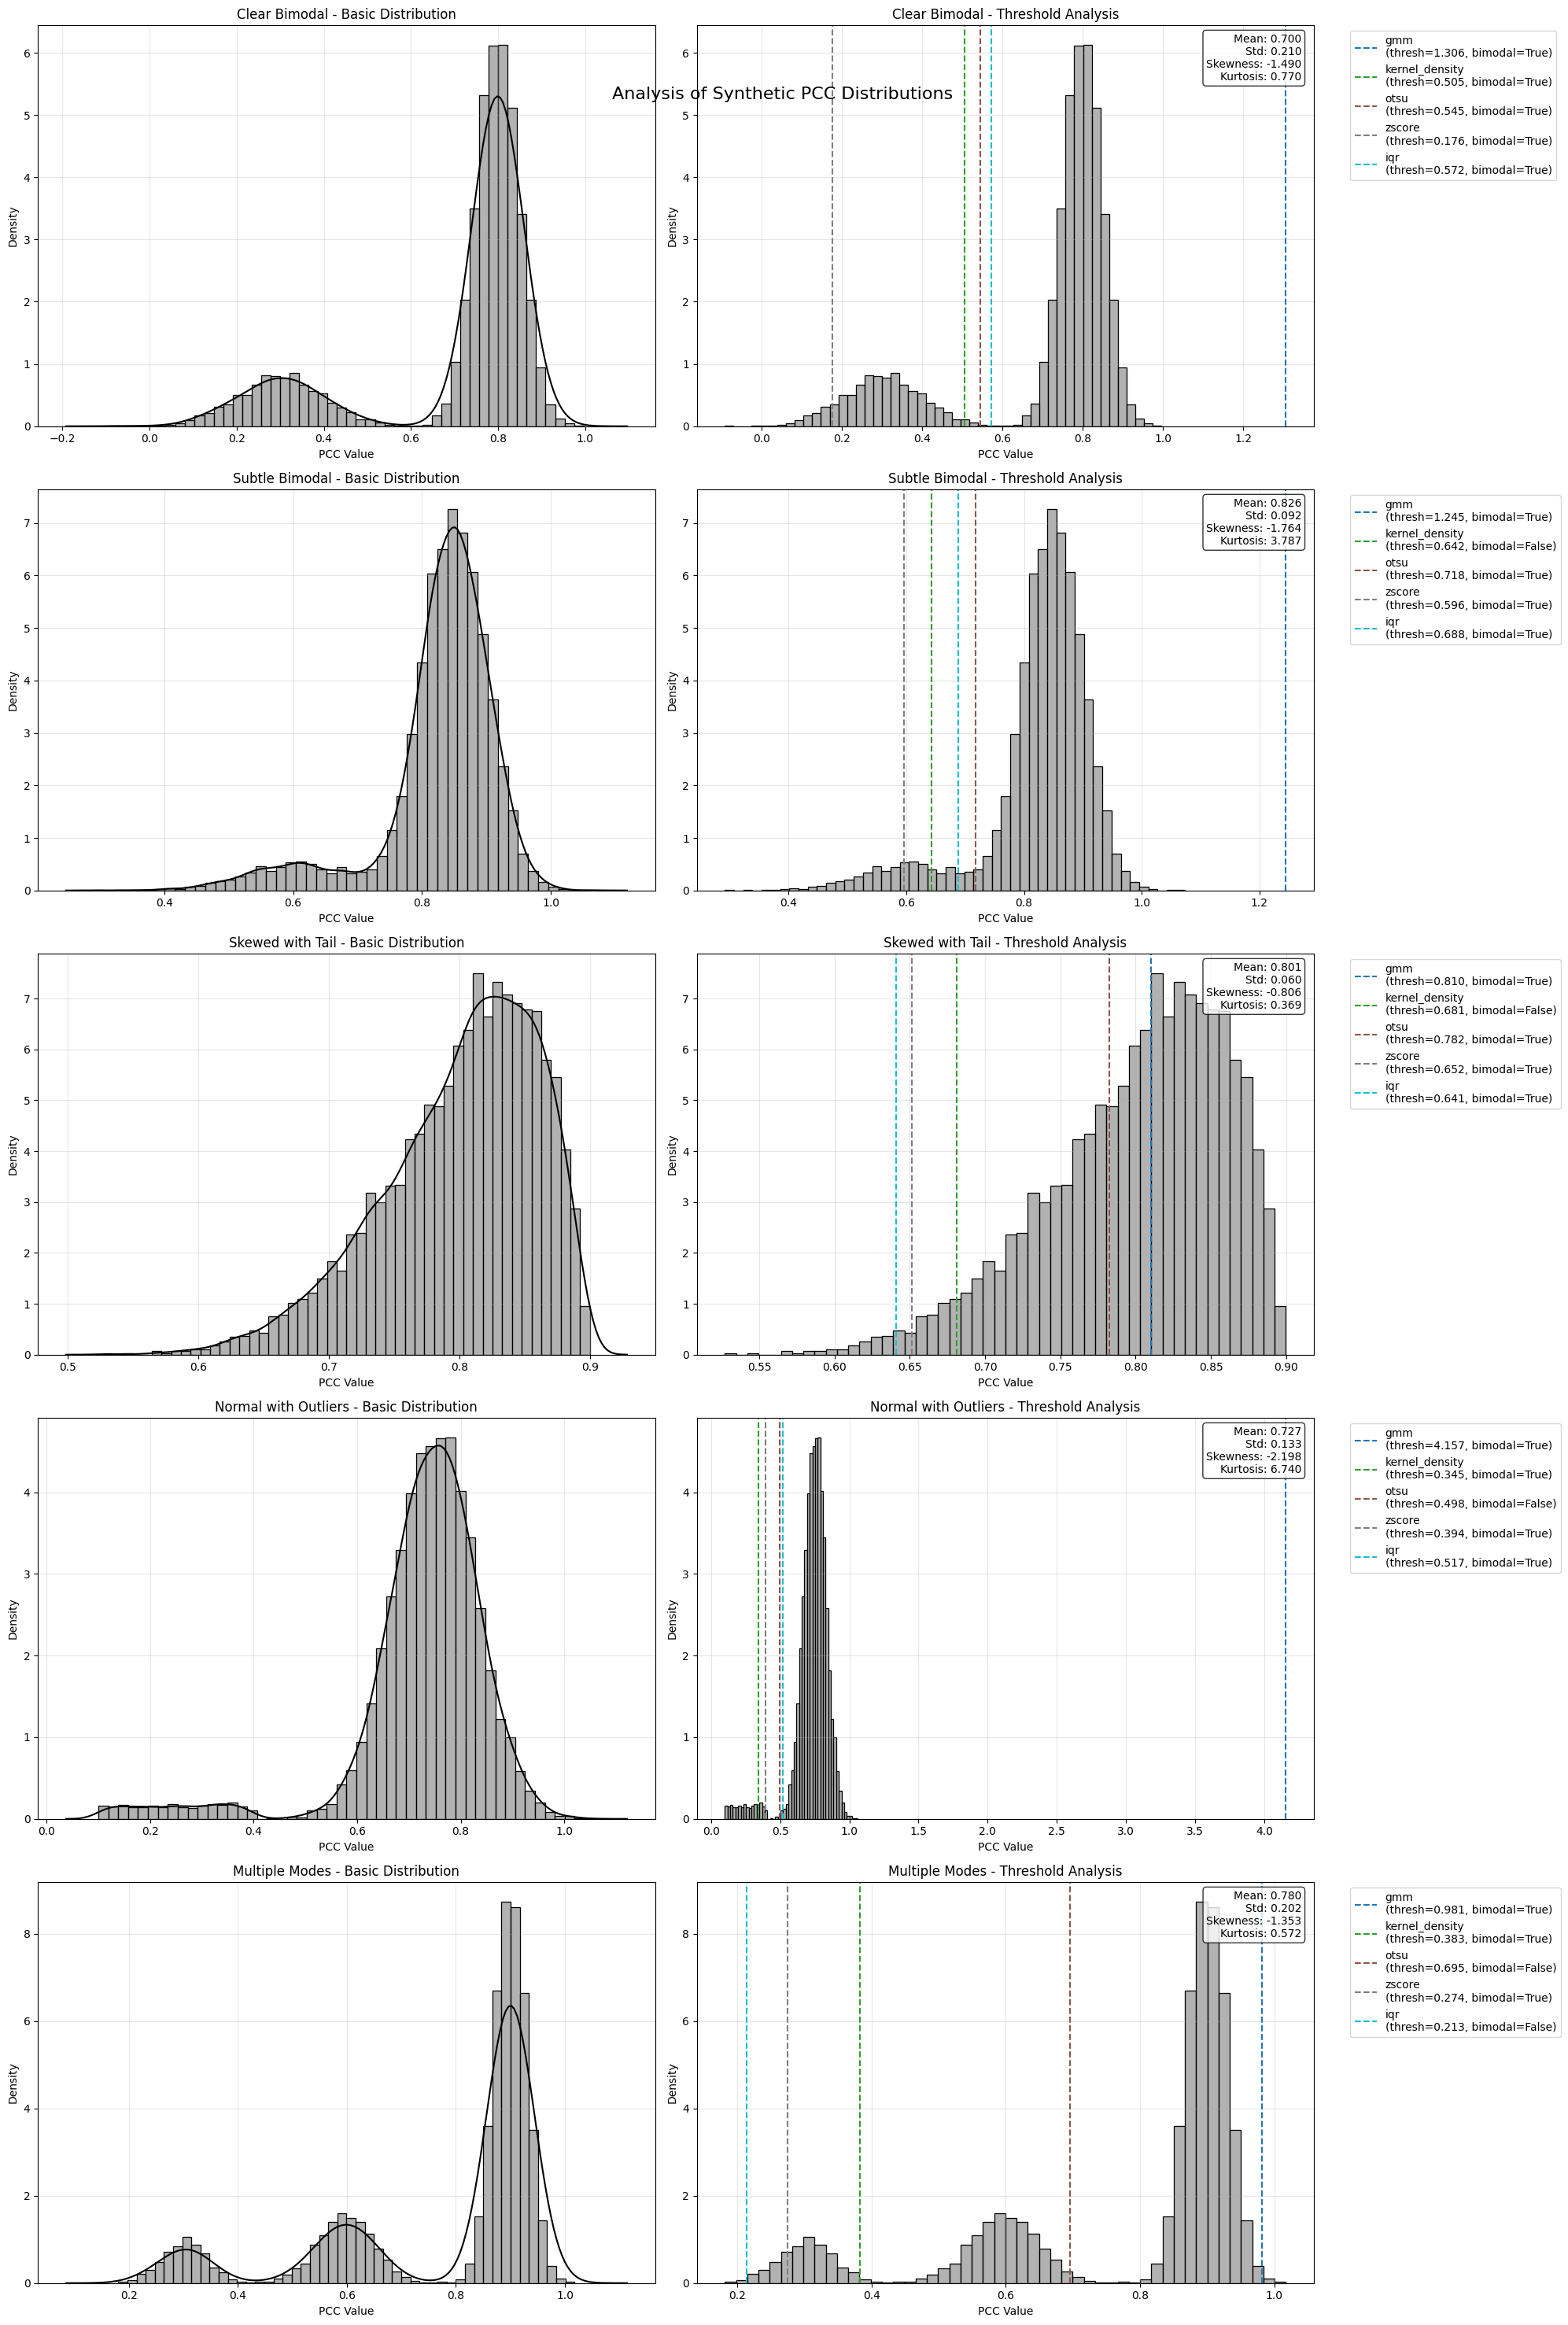

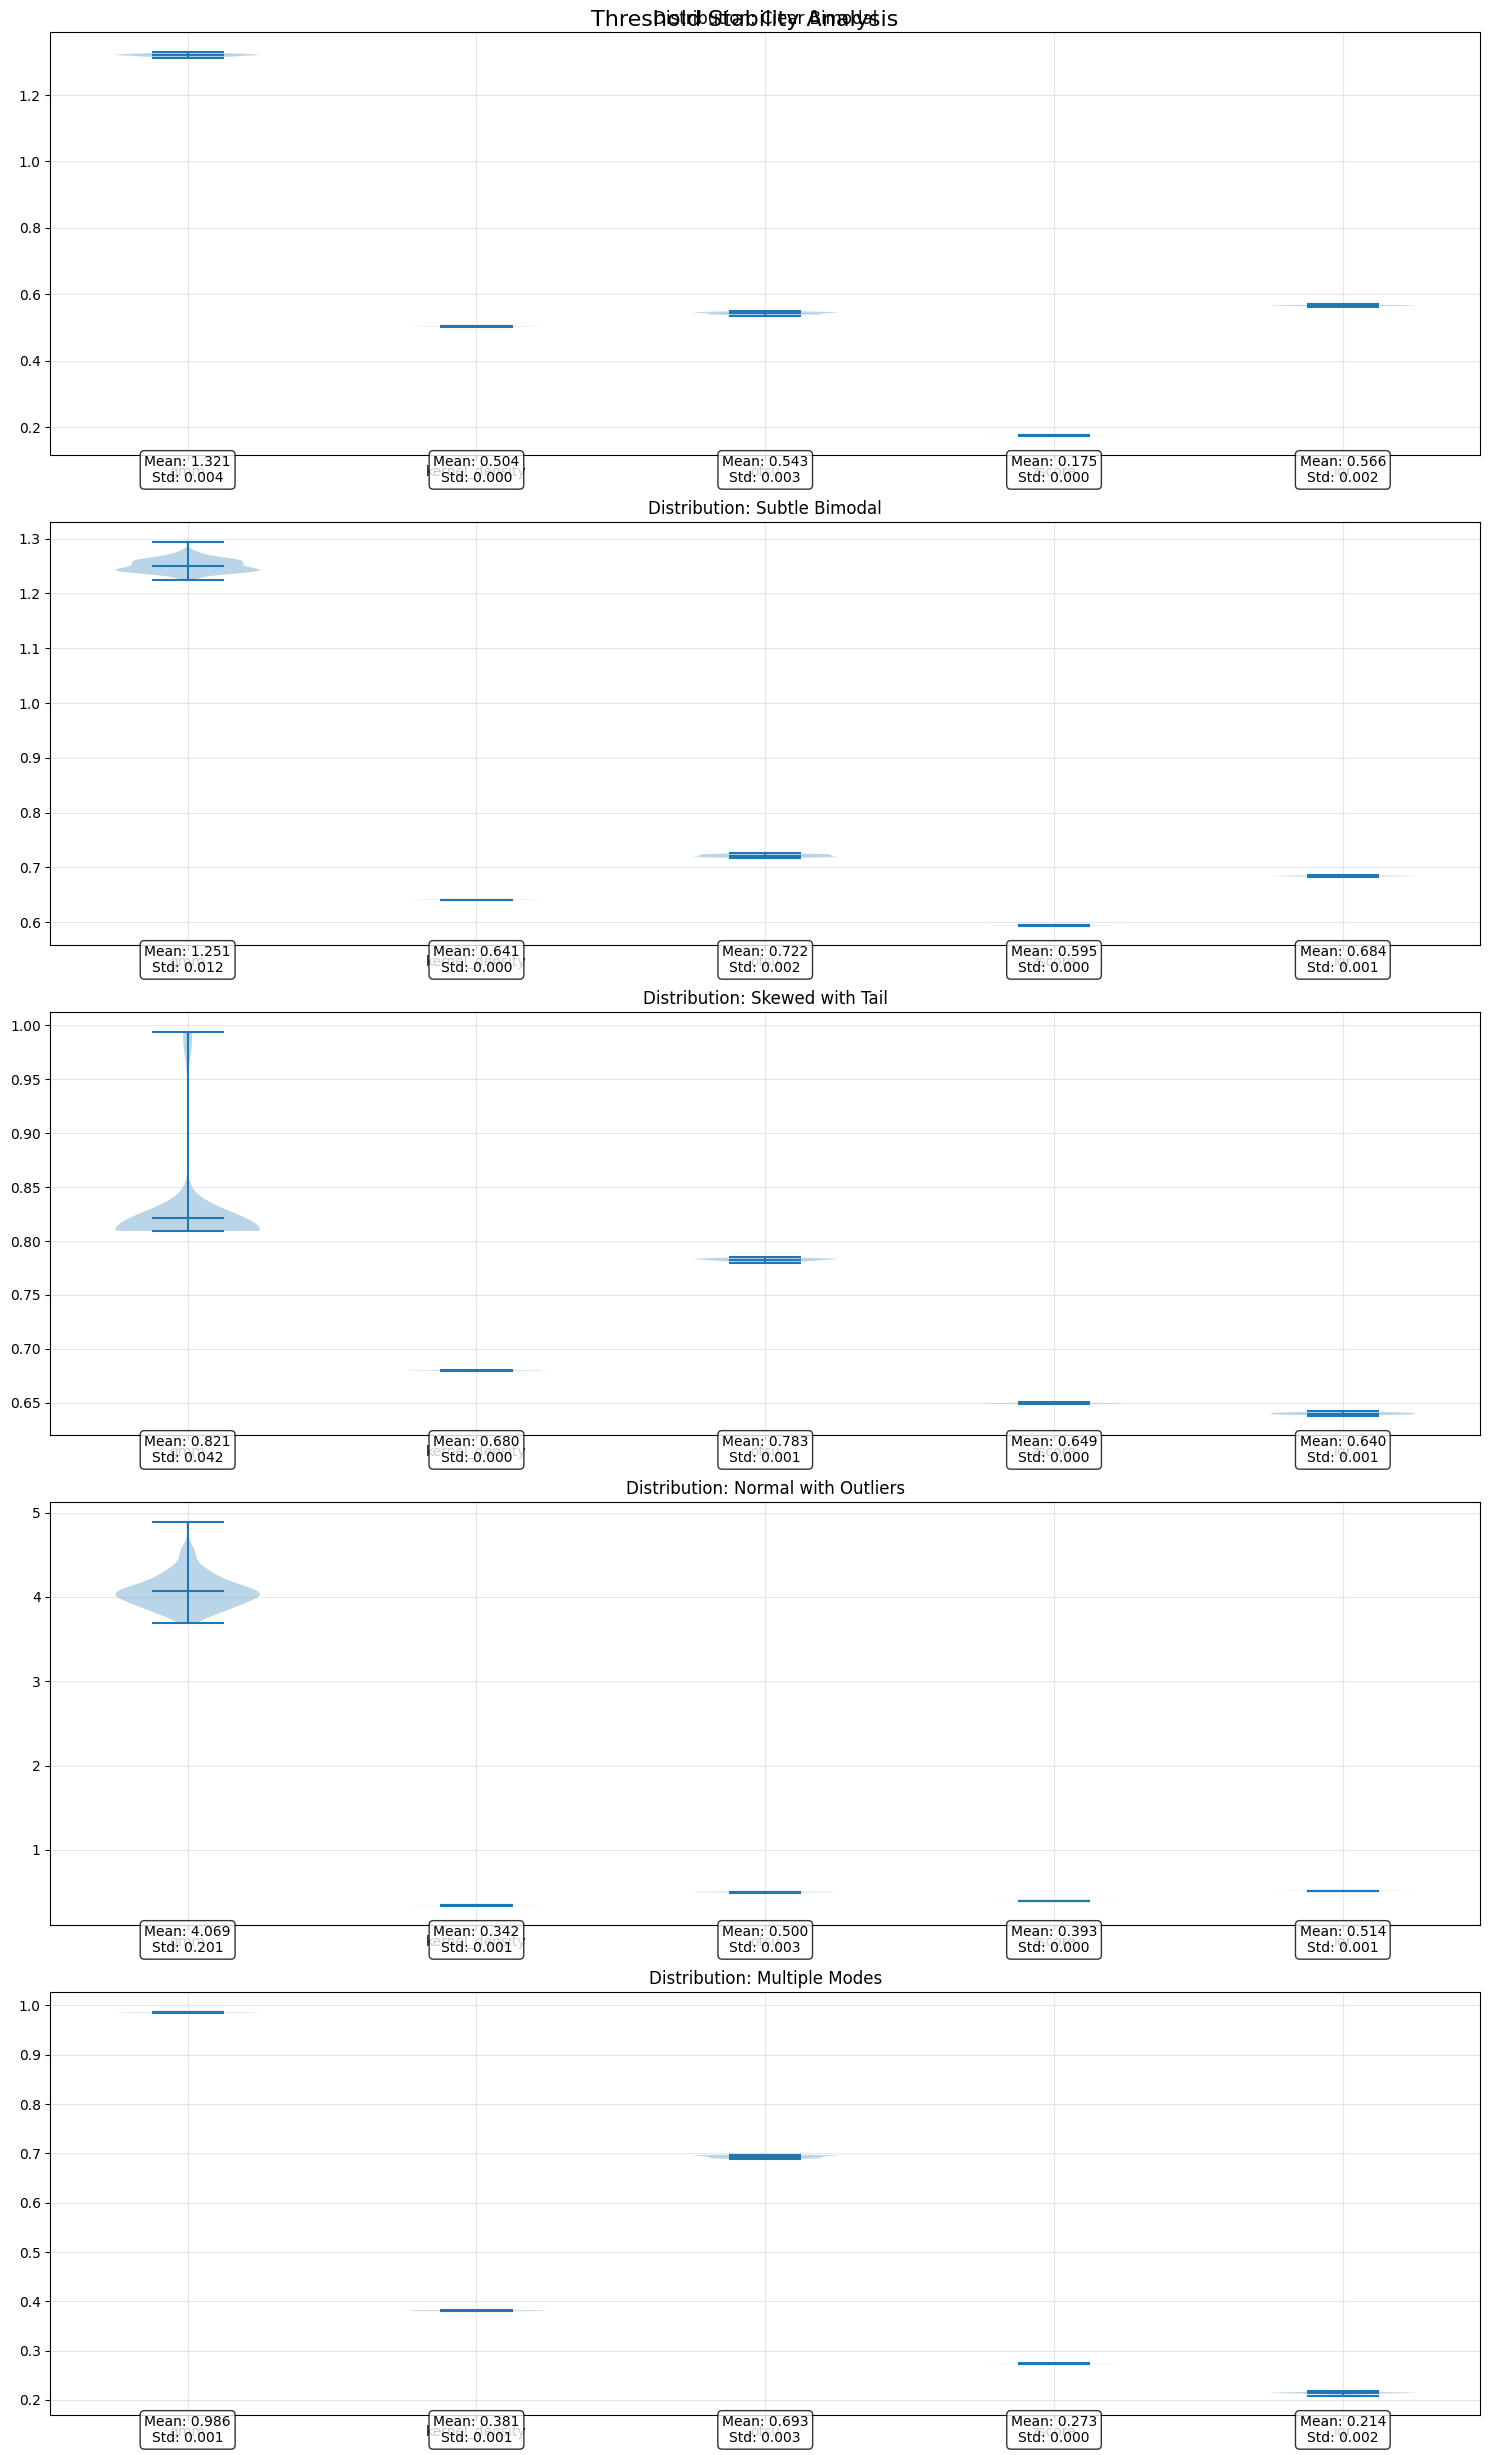


Summary Statistics:

Distribution: Clear Bimodal
--------------------------------------------------
gmm:
  Threshold: 1.306
  Bimodal: True
kernel_density:
  Threshold: 0.505
  Bimodal: True
otsu:
  Threshold: 0.545
  Bimodal: True
zscore:
  Threshold: 0.176
  Bimodal: True
iqr:
  Threshold: 0.572
  Bimodal: True

Distribution: Subtle Bimodal
--------------------------------------------------
gmm:
  Threshold: 1.245
  Bimodal: True
kernel_density:
  Threshold: 0.642
  Bimodal: False
otsu:
  Threshold: 0.718
  Bimodal: True
zscore:
  Threshold: 0.596
  Bimodal: True
iqr:
  Threshold: 0.688
  Bimodal: True

Distribution: Skewed with Tail
--------------------------------------------------
gmm:
  Threshold: 0.810
  Bimodal: True
kernel_density:
  Threshold: 0.681
  Bimodal: False
otsu:
  Threshold: 0.782
  Bimodal: True
zscore:
  Threshold: 0.652
  Bimodal: True
iqr:
  Threshold: 0.641
  Bimodal: True

Distribution: Normal with Outliers
--------------------------------------------------
g

In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import seaborn as sns

def generate_synthetic_distributions():
    """Generate different synthetic PCC distributions"""
    np.random.seed(42)
    n_samples = 10000
    
    # Case 1: Clear bimodal distribution (obvious anomalies)
    dist1_normal = np.random.normal(0.8, 0.05, int(n_samples * 0.8))
    dist1_anomaly = np.random.normal(0.3, 0.1, int(n_samples * 0.2))
    dist1 = np.concatenate([dist1_normal, dist1_anomaly])
    
    # Case 2: Subtle bimodal distribution (subtle anomalies)
    dist2_normal = np.random.normal(0.85, 0.05, int(n_samples * 0.9))
    dist2_anomaly = np.random.normal(0.6, 0.08, int(n_samples * 0.1))
    dist2 = np.concatenate([dist2_normal, dist2_anomaly])
    
    # Case 3: Skewed distribution with tail (gradual degradation)
    dist3 = np.random.beta(8, 2, n_samples) * 0.5 + 0.4
    
    # Case 4: Normal distribution with outliers
    dist4_normal = np.random.normal(0.75, 0.08, n_samples)
    dist4_outliers = np.random.uniform(0.1, 0.4, int(n_samples * 0.05))
    dist4 = np.concatenate([dist4_normal, dist4_outliers])
    
    # Case 5: Multiple modes (different types of anomalies)
    dist5_normal = np.random.normal(0.9, 0.03, int(n_samples * 0.7))
    dist5_anom1 = np.random.normal(0.6, 0.05, int(n_samples * 0.2))
    dist5_anom2 = np.random.normal(0.3, 0.04, int(n_samples * 0.1))
    dist5 = np.concatenate([dist5_normal, dist5_anom1, dist5_anom2])
    
    return {
        'Clear Bimodal': dist1,
        'Subtle Bimodal': dist2,
        'Skewed with Tail': dist3,
        'Normal with Outliers': dist4,
        'Multiple Modes': dist5
    }

def plot_distribution_analysis(distributions):
    """Plot comprehensive analysis of synthetic distributions"""
    methods = get_dynamic_threshold_methods()
    n_distributions = len(distributions)
    
    # Create figure with two columns
    fig, axs = plt.subplots(n_distributions, 2, figsize=(20, 6*n_distributions))
    fig.suptitle('Analysis of Synthetic PCC Distributions', fontsize=16, y=0.95)
    
    for idx, (name, dist) in enumerate(distributions.items()):
        # Left plot: Simple histogram with KDE
        sns.histplot(data=dist, bins=50, stat='density', alpha=0.6, 
                    color='gray', ax=axs[idx, 0])
        sns.kdeplot(data=dist, color='black', ax=axs[idx, 0])
        axs[idx, 0].set_title(f'{name} - Basic Distribution')
        axs[idx, 0].set_xlabel('PCC Value')
        axs[idx, 0].set_ylabel('Density')
        
        # Right plot: Histogram with threshold methods
        sns.histplot(data=dist, bins=50, stat='density', alpha=0.6, 
                    color='gray', ax=axs[idx, 1])
        
        # Calculate and plot thresholds
        colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
        for (method_name, method), color in zip(methods.items(), colors):
            threshold, is_bimodal = method(dist)
            axs[idx, 1].axvline(threshold, color=color, linestyle='--', 
                               label=f"{method_name}\n(thresh={threshold:.3f}, bimodal={is_bimodal})")
        
        # Add distribution statistics
        stats_text = f"Mean: {np.mean(dist):.3f}\n"
        stats_text += f"Std: {np.std(dist):.3f}\n"
        stats_text += f"Skewness: {stats.skew(dist):.3f}\n"
        stats_text += f"Kurtosis: {stats.kurtosis(dist):.3f}"
        
        axs[idx, 1].text(0.98, 0.98, stats_text,
                        transform=axs[idx, 1].transAxes,
                        verticalalignment='top',
                        horizontalalignment='right',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        axs[idx, 1].set_title(f'{name} - Threshold Analysis')
        axs[idx, 1].set_xlabel('PCC Value')
        axs[idx, 1].set_ylabel('Density')
        axs[idx, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Add grid
        axs[idx, 0].grid(True, alpha=0.3)
        axs[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, axs

def plot_threshold_stability(distributions):
    """Plot stability analysis of threshold methods"""
    methods = get_dynamic_threshold_methods()
    n_iterations = 100
    
    fig, axs = plt.subplots(len(distributions), 1, figsize=(15, 5*len(distributions)))
    fig.suptitle('Threshold Stability Analysis', fontsize=16)
    
    for idx, (name, dist) in enumerate(distributions.items()):
        thresholds = {method_name: [] for method_name in methods.keys()}
        
        # Calculate thresholds with noise
        for _ in range(n_iterations):
            noisy_dist = dist + np.random.normal(0, 0.01, len(dist))
            for method_name, method in methods.items():
                threshold, _ = method(noisy_dist)
                thresholds[method_name].append(threshold)
        
        # Create violin plot
        data = [thresholds[method] for method in methods.keys()]
        vp = axs[idx].violinplot(data, points=100, showmeans=True)
        
        # Customize plot
        axs[idx].set_xticks(range(1, len(methods) + 1))
        axs[idx].set_xticklabels(methods.keys())
        axs[idx].set_title(f'Distribution: {name}')
        axs[idx].grid(True, alpha=0.3)
        
        # Add statistics
        for i, method in enumerate(methods.keys(), 1):
            stats_text = f"Mean: {np.mean(thresholds[method]):.3f}\n"
            stats_text += f"Std: {np.std(thresholds[method]):.3f}"
            axs[idx].text(i, axs[idx].get_ylim()[0], stats_text,
                         horizontalalignment='center',
                         verticalalignment='top',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, axs

# Run the analysis
if __name__ == "__main__":
    # Generate synthetic distributions
    distributions = generate_synthetic_distributions()
    
    # Plot distribution analysis
    fig_dist, axs_dist = plot_distribution_analysis(distributions)
    plt.show()
    
    # Plot stability analysis
    fig_stab, axs_stab = plot_threshold_stability(distributions)
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    for name, dist in distributions.items():
        print(f"\nDistribution: {name}")
        print("-" * 50)
        for method_name, method in get_dynamic_threshold_methods().items():
            threshold, is_bimodal = method(dist)
            print(f"{method_name}:")
            print(f"  Threshold: {threshold:.3f}")
            print(f"  Bimodal: {is_bimodal}")